In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import resample

n_samples = 50000

HP = np.random.uniform(0, 4000, n_samples)
AS = np.random.uniform(0.5, 2.5, n_samples)
AD = np.random.uniform(94, 200, n_samples)
A = np.random.uniform(0, 400, n_samples)
MR = np.random.uniform(0, 400, n_samples)
CC = np.random.uniform(0, 1.5, n_samples)
CD = np.random.uniform(1.575, 1.935, n_samples)
LifeSteal = np.random.uniform(0, 0.57, n_samples)
HR = np.random.uniform(4, 35.4, n_samples)
Haste = np.random.uniform(0, 135, n_samples)
L = np.random.uniform(0, 102, n_samples)
RAP = np.random.choice(np.arange(0, 0.36, 0.06), n_samples)
ARP = np.random.choice([0, 0.18, 0.35], n_samples)

base_health = 2405

def calculate_effective_health(HP, A, MR):
    return HP * (1 + (((111.2 + A) / 100) + ((66.85 + MR) / 100)))

def determine_cooldowns(AS):
    bonus_attack_speed_percent = ((AS / 0.997) - 1) * 100
    
    W_thresholds = [0, 9.46, 18.91, 28.37, 37.82, 47.28, 56.73, 66.19, 75.64, 85.1, 94.55]
    Q_thresholds = [0.0, 0.15, 0.30, 0.45, 0.60, 0.75, 0.90, 1.05, 1.1111]

    W_cd_values = [14, 13.2, 12.4, 11.6, 10.8, 10, 9.2, 8.4, 7.6, 6.8, 6]
    Q_cd_values = [4, 3.64, 3.28, 2.92, 2.56, 2.2, 1.84, 1.48, 1.33]

    W_cd, Q_cd = W_cd_values[0], Q_cd_values[0]
    for i, threshold in enumerate(W_thresholds):
        if bonus_attack_speed_percent <= threshold:
            W_cd = W_cd_values[i]
            break
    for i, threshold in enumerate(Q_thresholds):
        if bonus_attack_speed_percent <= threshold:
            Q_cd = Q_cd_values[i]
            break
    return W_cd, Q_cd

def compute_cpv(HP, AS, AD, A, MR, CC, CD, LifeSteal, HR, Haste, base_health, ARP, RAP, L):
    
    if CC > 0.5:
        excess_CC = CC - 0.5
        AD += 50 * excess_CC
        CC = 0.5  

    W_cd, Q_cd = determine_cooldowns(AS)
    effective_health = (2405 + HP) * (1 + (((111.2 + A) / 100) + ((66.85 + MR) / 100)))
    DPS_A = AS * (AD + AD * (2*CC * (CD - 1)))
    Q_dps = (120 + (1.05 * AD) + (120 + (1.05 * AD)) * (2*CC * (0.6037 + CD - 1.575))) / Q_cd
    W_a = 412
    DPS_P = (Q_dps + W_a / W_cd) + (0.35 * (Q_dps + W_a / W_cd) / (10 * (100 / (100 + Haste))))
    denominator = ((1 - ARP) * (1 - RAP) * (111.2+A)) - L
    denominator = max(denominator, 1e-9)
    DPS_C = (DPS_A + DPS_P) * (100 / denominator)
    e_value = calculate_effective_health(((DPS_A * LifeSteal) + HR), A, MR)
    CPV = DPS_C * ((effective_health / base_health) + (e_value / base_health))
    return CPV

CPV = np.array([compute_cpv(HP[i], AS[i], AD[i], A[i], MR[i], CC[i], CD[i], LifeSteal[i], HR[i], Haste[i], base_health, L[i], ARP[i], RAP[i]) for i in range(n_samples)])

data = pd.DataFrame({
    "HP": HP,
    "AS": AS,
    "AD": AD,
    "Armor": A,
    "MR": MR,
    "Crit Chance": CC,
    "Crit Damage": CD,
    "Life Steal": LifeSteal,
    "Health Regen": HR,
    "Haste": Haste,
    "Lethality": L,
    "ArmPen": ARP,
    "PercentReduc": RAP,
    "CPV": CPV
})


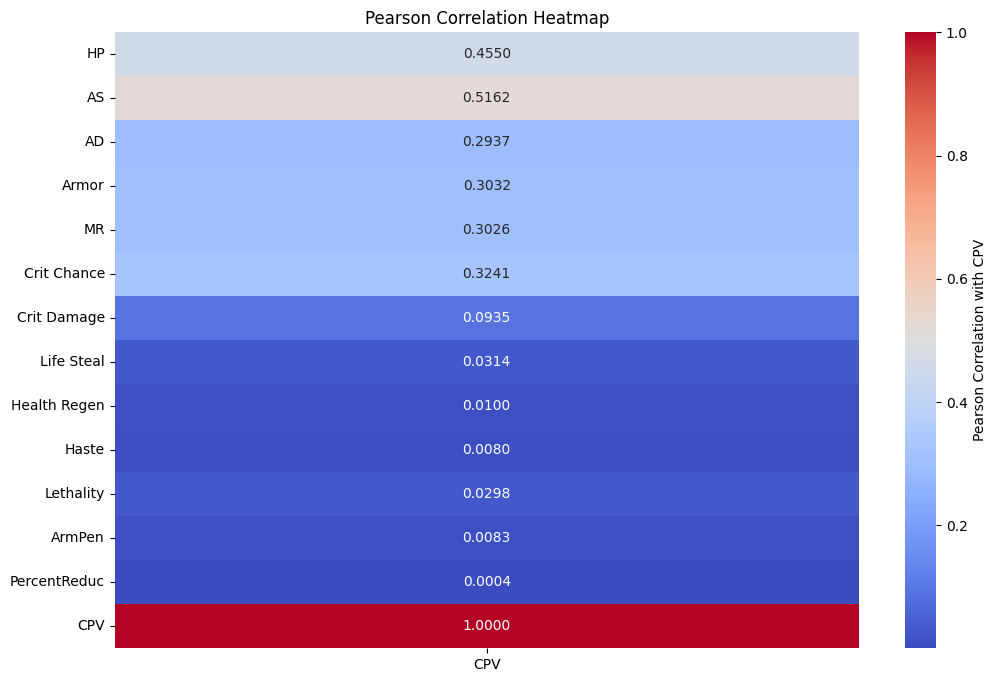

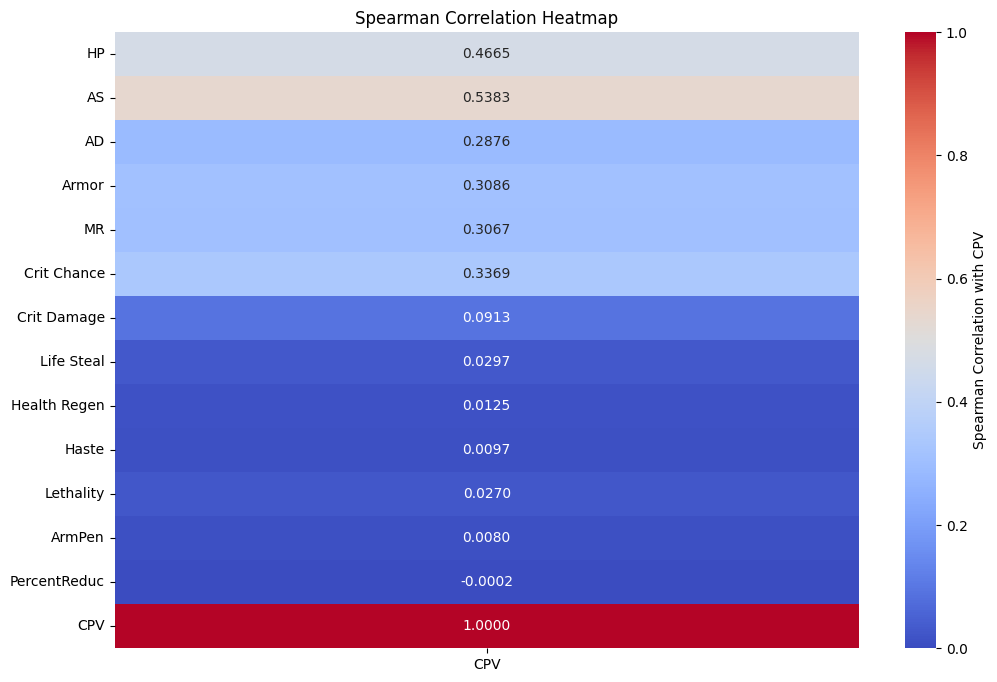

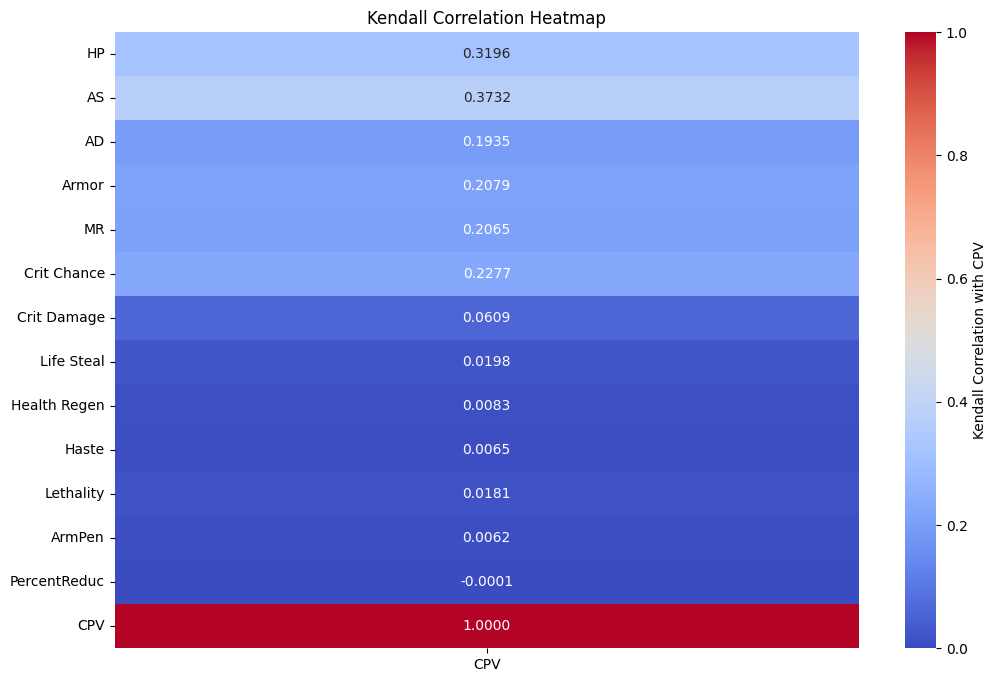

C:\Users\User\AppData\Local\Temp\ipykernel_17208\4034573624.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="feature", data=vif_data, palette="viridis")


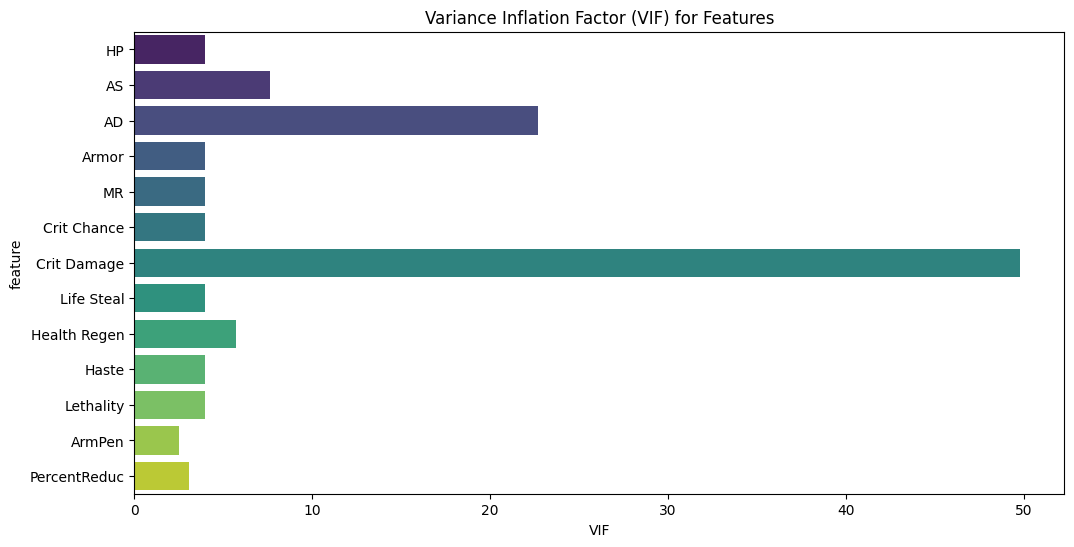

In [51]:
pearson_corr = data.corr()
spearman_corr = data.corr(method=lambda x, y: spearmanr(x, y)[0])
kendall_corr = data.corr(method=lambda x, y: kendalltau(x, y)[0])

plt.figure(figsize=(12, 8))
sns.heatmap(pearson_corr[["CPV"]], annot=True, cmap="coolwarm", fmt=".4f", cbar_kws={'label': 'Pearson Correlation with CPV'})
plt.title("Pearson Correlation Heatmap")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr[["CPV"]], annot=True, cmap="coolwarm", fmt=".4f", cbar_kws={'label': 'Spearman Correlation with CPV'})
plt.title("Spearman Correlation Heatmap")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(kendall_corr[["CPV"]], annot=True, cmap="coolwarm", fmt=".4f", cbar_kws={'label': 'Kendall Correlation with CPV'})
plt.title("Kendall Correlation Heatmap")
plt.show()

X = data.drop(columns=["CPV"])
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

plt.figure(figsize=(12, 6))
sns.barplot(x="VIF", y="feature", data=vif_data, palette="viridis")
plt.title("Variance Inflation Factor (VIF) for Features")
plt.show()
